In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.
    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)


def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.
    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)

## Create a true distribution

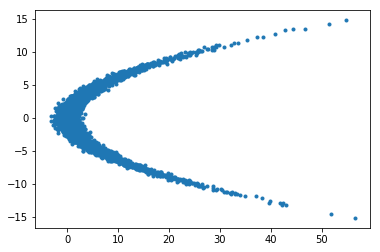

In [2]:
batch_size = 5120
distrib = Normal(loc=0., scale=4.)
x2 = distrib.sample(torch.Size([batch_size]))
distrib2 = Normal(loc=.25 * (x2 ** 2), scale=torch.ones_like(x2))
x1 = distrib2.sample()
samples = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1)], dim=1)

# plot ot
plt.scatter(samples[:, 0], samples[:, 1], marker='.')

In [3]:
from torch.distributions.transforms import Transform, AffineTransform, SigmoidTransform, ComposeTransform

class LeakyReLU(Transform):
    def __init__(self, alpha=0.5):
        super(LeakyReLU, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([alpha]))

    def __eq__(self, other):
        return isinstance(other, LeakyReLU)
    
    def _call(self, x):
        return torch.where(x >= 0, x, self.alpha * x)

    def _inverse(self, y):
        return torch.where(y >= 0, y, 1. / self.alpha * y)

    def log_abs_det_jacobian(self, x, y):
        #event_dims = self._event_dims_tensor(y)
        I = torch.ones_like(x)
        J_inv = torch.where(x >= 0, I, self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = torch.log(torch.abs(J_inv))
        return -log_abs_det_J_inv
    
class AffineNormalizingFlow(Transform):
    
    def __init__(self, in_features):
        super(AffineNormalizingFlow, self).__init__()
        self.loc = nn.Parameter(torch.randn(in_features))
        self.scale = nn.Parameter(torch.randn(in_features))
        self.affine = AffineTransform(loc=self.loc, scale=self.scale)
        self.leakyReLU = LeakyReLU()
        self.transformer = ComposeTransform([self.affine, self.leakyReLU])
        
    def __eq__(self, other):
        return isinstance(other, AffineNormalizingFlow)
    
    def _call(self, x):
        return self.transformer(x)
    
    def _inverse(self, y):
        return self.transformer.inv(y)

    def log_abs_det_jacobian(self, x, y):
        return self.transformer.log_abs_det_jacobian(x, y)

In [4]:
class SimpleFlows(nn.Module):
    
    def __init__(self, num_layers=2):
        super(SimpleFlows, self).__init__()
        self.num_layers = num_layers
        self.flows = [AffineNormalizingFlow(2) for i in range(num_layers)]
        self.bijectors = ComposeTransform(self.flows)
        
        # add parameters
        for i in range(num_layers):
            self.register_parameter("loc_{}".format(i), self.flows[i].loc)
            self.register_parameter("scale_{}".format(i), self.flows[i].scale)
            self.register_parameter("alpha_{}".format(i), self.flows[i].leakyReLU.alpha)
            
    def forward(self, x):
        return self.bijectors(x)
    
    def inverse(self, y):
        return self.bijectors.inv(y)
    
    def log_prob(self, y):
        x = self.bijectors.inv(y)
        base_log_prob = log_standard_gaussian(x)
        log_abs_det_jacobian = self.bijectors.log_abs_det_jacobian(x, y)
        #return base_log_prob + log_abs_det_jacobian.sum(dim=1)
        return log_abs_det_jacobian.sum(dim=1)
    
model = SimpleFlows(num_layers=8)

In [5]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
for n in range(epochs):
    log_prob = model.log_prob(samples)
    loss = -log_prob.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if n % 500 == 0:
        print("epoch: {} loss: {}".format(n+1, loss.item()))

epoch: 1 loss: -0.9124614000320435
epoch: 501 loss: -54.41838455200195


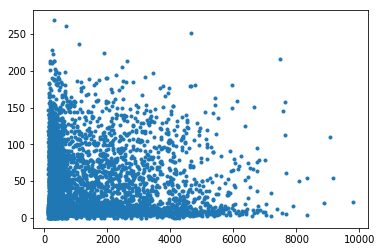

In [6]:
with torch.no_grad():
    eps = torch.FloatTensor(samples.size()).normal_()
    generated_samples = model(eps)
    generated_samples = generated_samples.numpy()
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], marker='.')